In [1]:
import xarray as xr
import pandas as d
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Phase-based velocity

In [2]:
ice_vel = xr.load_dataset("/home/kim/data/nsidc/antarctic_ice_vel_phase_map_v01.nc")

# Define new variable: speed V: sqrt(VX**2 + VY**2)
# hypot is numerically more stable than sqrt(VX**2 + VY**2)
ice_vel["V"] = np.hypot(ice_vel["VX"], ice_vel["VY"])

In [3]:
# Define corners in Antarctic Polar Stereographic coordinates (APSC)
x_min = 1_700_000
x_max = 2_700_000
y_min = - 1_400_000
y_max = - 400_000

# 1_400 km x 1_400 km box (5_500 km across the continent)
# 1_400 km reach of Twin Otter
# 1_760 km - 3_900 km long range of Basler
x_min = 1_300_000
x_max = 2_700_000
y_min = - 1_600_000
y_max = - 200_000

# Define skiway coordinates for vis
skiway_y = - 926_321.561224
skiway_x = 2_442_514.460804

ice_vel_casey = ice_vel.sel(
    x = slice(x_min, x_max), 
    y = slice(y_max, y_min))

print(ice_vel_casey.V.shape)

(3111, 3111)


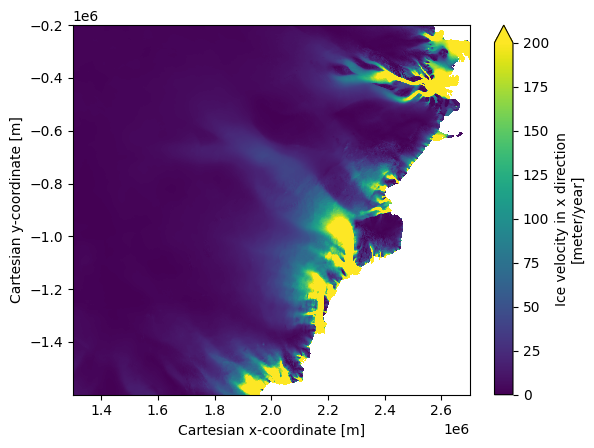

In [7]:
ice_vel_casey.V.plot(vmin = 0, vmax = 200)

# Visualise

# 
align_corners = True → ±1 map to the centers of the corner pixels

# Repeat with buffer for interpolation

In [ ]:
# Crop with buffer for interpolation of edges
buffer = 2_000

x_min_buffer = 1_300_000 - buffer
x_max_buffer = 2_700_000 + buffer
y_min_buffer = - 1_600_000 - buffer
y_max_buffer = - 200_000 + buffer

ice_vel_casey_buffer = ice_vel.sel(
    x = slice(x_min_buffer, x_max_buffer), 
    y = slice(y_max_buffer, y_min_buffer))

print(ice_vel_casey_buffer.V.shape)

grid_x_minus_one = ice_vel_casey_buffer.x.values.min().item()
grid_x_plus_one = ice_vel_casey_buffer.x.values.max().item()
grid_y_minus_one = ice_vel_casey_buffer.y.values.min().item()
grid_y_plus_one = ice_vel_casey_buffer.y.values.max().item()

print(grid_x_minus_one, grid_x_plus_one)
print(grid_y_minus_one, grid_y_plus_one)

(3120, 3120)
1298150.0 2701700.0
-1601900.0 -198350.0


# Export tensor

In [41]:
print(ice_vel_casey_buffer.x.values[:5])   # first few x
print(ice_vel_casey_buffer.y.values[:5])  

[1298150. 1298600. 1299050. 1299500. 1299950.]
[-198350. -198800. -199250. -199700. -200150.]


In [ ]:
ice_vel_casey_buffer.x.values

XX, YY = torch.meshgrid(
    # x values increase to the right (eastwards)
    torch.tensor(ice_vel_casey_buffer.x.values, dtype = torch.float32),
    # y values decrease to the bottom (southwards)
    torch.tensor(ice_vel_casey_buffer.y.values, dtype = torch.float32), 
    indexing = 'xy')

# YX order (row major)
# (top left indexed as (0, 0))
ice_speed_grid = torch.stack([YY, XX, torch.tensor(ice_vel_casey_buffer.V.values)], dim = 0)
print(ice_speed_grid.shape)

torch.save(ice_speed_grid, "data/ice_speed_grid_casey_YX.pt")

torch.Size([3, 3120, 3120])


In [43]:
ice_speed_grid[0, :]

tensor([[ -198350.,  -198350.,  -198350.,  ...,  -198350.,  -198350.,
          -198350.],
        [ -198800.,  -198800.,  -198800.,  ...,  -198800.,  -198800.,
          -198800.],
        [ -199250.,  -199250.,  -199250.,  ...,  -199250.,  -199250.,
          -199250.],
        ...,
        [-1601000., -1601000., -1601000.,  ..., -1601000., -1601000.,
         -1601000.],
        [-1601450., -1601450., -1601450.,  ..., -1601450., -1601450.,
         -1601450.],
        [-1601900., -1601900., -1601900.,  ..., -1601900., -1601900.,
         -1601900.]])

In [9]:
ice_vel_casey.isel(x = 10, y = 20)
ice_vel_casey.isel(x = 34, y = 33)
ice_vel_casey.isel(x = 2000, y = 2000)

<xarray.Dataset> Size: 66B
Dimensions:       ()
Coordinates:
    x             float64 8B 2.2e+06
    y             float64 8B -1.1e+06
    lat           float64 8B -67.63
    lon           float64 8B 116.6
Data variables:
    coord_system  |S1 1B b''
    VX            float32 4B 97.92
    VY            float32 4B -18.88
    STDX          float32 4B 11.87
    STDY          float32 4B 9.49
    ERRX          float32 4B 0.7982
    ERRY          float32 4B 0.6383
    CNT           int32 4B 221
    SOURCE        int8 1B 1
    V             float32 4B 99.72
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

In [ ]:
1.506
1.643
99.72

In [ ]:
torch.tensor(
    [1304900., -209150.],
    [1315700., -215000.],
    [2200400., -1100150.]
)

<>:2: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:2: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
/tmp/ipykernel_907380/4186142718.py:2: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [ice_vel_casey_buffer.y.values[20], ice_vel_casey_buffer.x.values[10], ice_vel_casey_buffer.V.values[20, 10]]
/tmp/ipykernel_907380/4186142718.py:2: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [ice_vel_casey_buffer.y.values[20], ice_vel_casey_buffer.x.values[10], ice_vel_casey_buffer.V.values[20, 10]]
/tmp/ipykernel_907380/4186142718.py:2: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [ice_vel_casey_buffer.y.values[20], ice_vel_casey_buffer.x.values[10], ice_vel_casey_buffer.V.values[20, 10]]
/tmp/ipykernel_907380/4186142718.py:2: SyntaxWarning: list i

NameError: name 'ice_vel_casey_buffer' is not defined

In [ ]:
def to_grid_xy(XY, x_1d, y_1d, align_corners = True):
    
    Nx, Ny = x_1d.numel(), y_1d.numel()
    j = (XY[..., 0] - x_1d[0]) / (x_1d[-1] - x_1d[0]) * (Nx - 1)  # fractional col
    i = (XY[..., 1] - y_1d[0]) / (y_1d[-1] - y_1d[0]) * (Ny - 1)  # fractional row
    if align_corners:
        gx = 2.0 * (j / (Nx - 1)) - 1.0
        gy = 2.0 * (i / (Ny - 1)) - 1.0
    else:
        gx = (2.0 * j + 1.0) / Nx - 1.0
        gy = (2.0 * i + 1.0) / Ny - 1.0

    return torch.stack([gx, gy], dim = -1)

In [ ]:
# Convert XY coordinates to grid coordinates for interpolation
# For the grid:
grid_x_minus_one = 1298150.0
grid_x_plus_one = 2701700.0
grid_y_minus_one = -1601900.0
grid_y_plus_one = -198350.0

grid = to_grid_xy(XY, x, y, align_corners = True).view(1, -1, 1, 2)

In [ ]:
import torch, torch.nn.functional as F

# 1D axes and field
x = torch.tensor(ice_vel_casey_buffer.x.values, dtype = torch.float32)   # (Nx,)
y = torch.tensor(ice_vel_casey_buffer.y.values, dtype = torch.float32)   # (Ny,)
V = torch.tensor(ice_vel_casey_buffer.V.values, dtype = torch.float32)   # (Ny, Nx)
field = V.unsqueeze(0).unsqueeze(0)  # (1,1,Ny,Nx)

def to_grid_xy(XY, x_1d, y_1d, align_corners = True):
    Nx, Ny = x_1d.numel(), y_1d.numel()
    j = (XY[..., 0] - x_1d[0]) / (x_1d[-1] - x_1d[0]) * (Nx - 1)  # fractional col
    i = (XY[..., 1] - y_1d[0]) / (y_1d[-1] - y_1d[0]) * (Ny - 1)  # fractional row
    if align_corners:
        gx = 2.0 * (j / (Nx - 1)) - 1.0
        gy = 2.0 * (i / (Ny - 1)) - 1.0
    else:
        gx = (2.0 * j + 1.0) / Nx - 1.0
        gy = (2.0 * i + 1.0) / Ny - 1.0
    return torch.stack([gx, gy], dim=-1)

# Example queries (M,2)
XY = torch.tensor([[1304900, -209150]], dtype=torch.float32)

grid = to_grid_xy(XY, x, y, align_corners = True).view(1, -1, 1, 2)
vals = F.grid_sample(field, grid, mode='bilinear', padding_mode='border', align_corners=True)
vals = vals.squeeze(0).squeeze(0).squeeze(-1)  # (M,)
vals

tensor([1.5063])

In [ ]:
torch.nn.functional.grid_sample(
    field, 
    grid = torch.tensor(ice_vel_casey_buffer.V.values[None, None, :, :])
    mode = 'bilinear', 
    # [-1, -1] is e.g. the center of the top-left pixel
    align_corners = True, 
    padding_mode = 'border')

In [ ]:
def to_grid_xy(XY, x, y):
    Nx, Ny = x.numel(), y.numel()
    j = (XY[..., 0] - x[0]) / (x[-1] - x[0]) * (Nx - 1)   # fractional col index
    i = (XY[..., 1] - y[0]) / (y[-1] - y[0]) * (Ny - 1)   # fractional row index
    gx = 2 * (j / (Nx - 1)) - 1
    gy = 2 * (i / (Ny - 1)) - 1
    return torch.stack([gx, gy], -1)                      # (..., 2)

# Example: sample M points
XY = torch.tensor([[1.75e6, -9.0e5],
                   [2.10e6, -1.2e6]], dtype=torch.float32)   # (M,2)
grid = to_grid_xy(XY, x, y).view(1, -1, 1, 2)                # (1,M,1,2)

In [11]:
torch.nn.functional.grid_sample(
    input = torch.tensor([[[[0.2, 0.2]]]]), # (N, H_out, W_out, 2)
    grid = torch.tensor(ice_vel_casey.V.values[None, None, :, :]), # (N = 1, C = 1, H, W)
    mode = 'bilinear',
    padding_mode = 'border',
    align_corners = True
)

RuntimeError: grid_sampler(): expected grid to have size 2 in last dimension, but got grid with sizes [1, 1, 3111, 3111]

In [4]:
torch.nn.functional.grid_sample(
    input = torch.tensor(ice_vel_casey.V.values[None, None, :, :], dtype = torch.float32),
    grid = torch.tensor([[[[0.0, 0.0]]]], dtype = torch.float32), # (N, H_out, W_out, 2)
    mode = 'bilinear',
    padding_mode = 'border',
    align_corners = True
)

tensor([[[[23.7198]]]])

## Custom colorscale

logarithmic color scale inspired by [this NASA article](https://earthobservatory.nasa.gov/images/146709/denman-glacier-losing-some-of-its-footing)

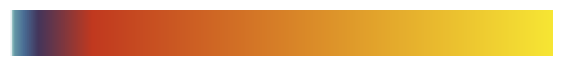

In [10]:
# Define color stops (positions from 0 to 1)
positions = [0.0, 0.1, 2.0, 5.0, 10.0, 50.0, 100.0, 300.0, 2000.0]  # uneven spacing
positions = np.array(positions) / 2000.0

# Define corresponding RGB or hex colors
colors = ["#eff5f8", "#CEE3E4", "#B3D2CD", "#9ACAC2", "#669AA8", "#486A93", "#43355B", "#C1391F", "#F7E634"]

# Create the custom colormap
icevel_cmap = LinearSegmentedColormap.from_list("custom_irregular", list(zip(positions, colors)))

# Display the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)

plt.figure(figsize = (7, 0.6))
plt.imshow(gradient, aspect = "auto", cmap = icevel_cmap)
plt.axis("off")
plt.show()

## VX component

/home/kim/anaconda3/envs/dfngp_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


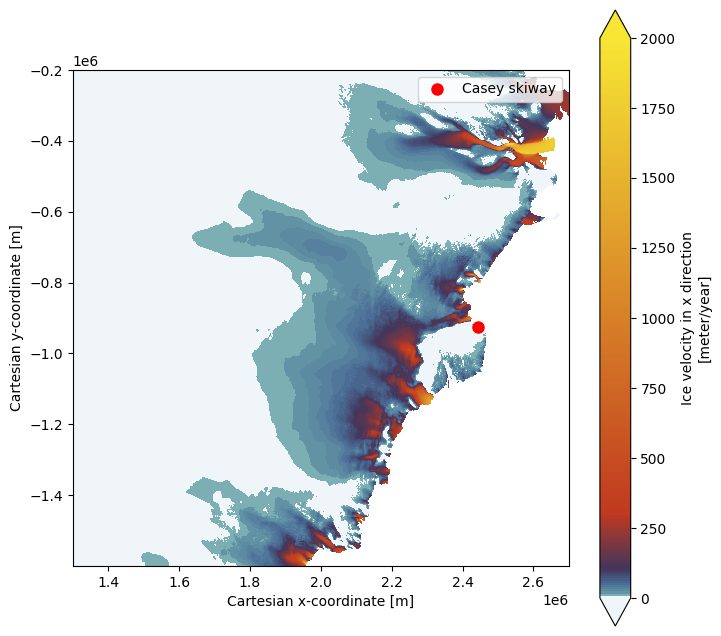

In [11]:
fig, ax = plt.subplots(figsize = (8, 8))

# Plot using pcolormesh
ice_vel_casey.VX.plot.pcolormesh(ax = ax, cmap = icevel_cmap, vmin = 0, vmax = 2000)

# Add a marker/dot for the skiway
ax.plot(skiway_x, skiway_y, "ro", markersize = 8, label = "Casey skiway")

ax.set_aspect("equal")
ax.legend()
plt.show()

## V component

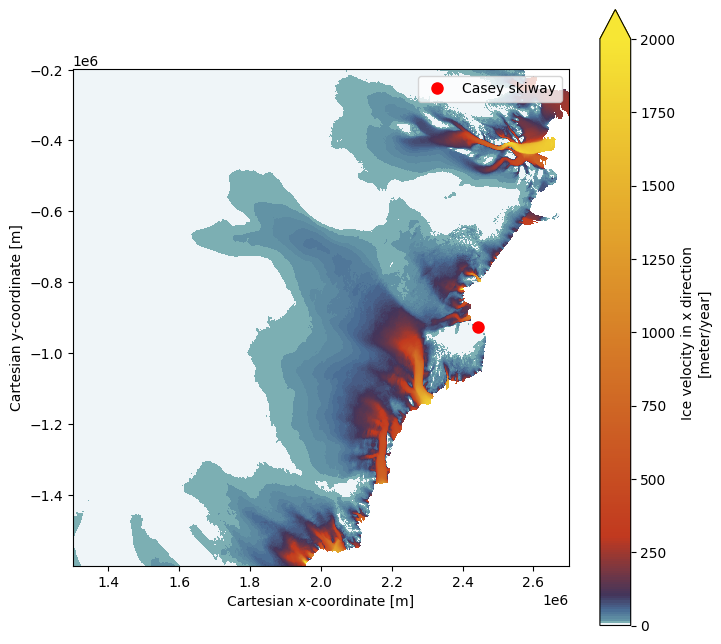

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

# Plot using pcolormesh
ice_vel_casey.V.plot.pcolormesh(ax = ax, cmap = icevel_cmap, vmin = 0, vmax = 2000)

# Add a marker/dot for the skiway
ax.plot(skiway_x, skiway_y, "rX", markersize = 8, label = "Casey skiway")

ax.set_aspect("equal")
ax.legend()
plt.show()

## VY plot

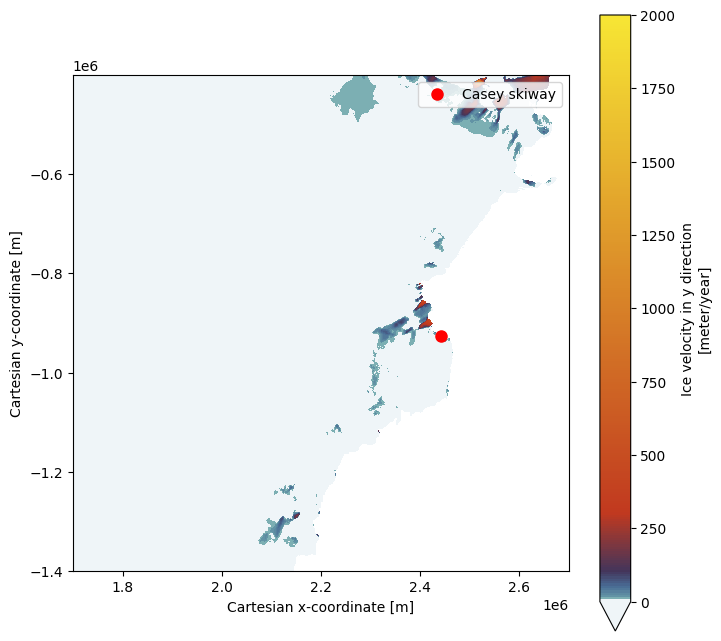

In [11]:
fig, ax = plt.subplots(figsize = (8, 8))

# Plot using pcolormesh
ice_vel_casey.VY.plot.pcolormesh(ax = ax, cmap = icevel_cmap, vmin = 0, vmax = 2000)

# Add a marker/dot for the skiway
ax.plot(skiway_x, skiway_y, "ro", markersize = 8, label = "Casey skiway")

ax.set_aspect("equal")
ax.legend()
plt.show()